In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Fetching the Data

In [170]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

# baseline_harmonized = baseline_harmonized.rename(
#     columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
# ).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

## Data Fusion TEDS-A + CTN 27

In [171]:
ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

ct94_cc = ct94[common_cols].drop(columns=["edu", "mar"])
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0
# ct94_cc["mar"].loc[(1 - ct94_cc["mar"].isna()) == 1] = (ct94_cc["mar"] == 1.0).astype(
#     int
# )
# ct94_cc["edu"].loc[(1 - ct94_cc["edu"].isna()) == 1] = (ct94_cc["edu"] >= 2.0).astype(
#     int
# )

imputer = KNNImputer(n_neighbors=4, weights="distance", add_indicator=False)
ct94_cc_imputed = imputer.fit_transform(ct94_cc)

ct94_cc = pd.DataFrame(ct94_cc_imputed, index=ct94_cc.index, columns=ct94_cc.columns)

ct94_cc["med_met"] = (ct94[treatment_col] == "met").astype(
    int
)  # methadone = 1 and bupenorphine = 0
ct94_cc = ct94_cc.dropna()

ct94_cc["S"] = 1
ct94_cc = ct94_cc.round(0).astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")
print(ct94_cc.shape)
ct94_cc.groupby(by="med_met").mean()[outcome_cols]

(1271, 11)


opioiduse12  opioiduse24
med_met                          
0           0.629380     0.750674
1           0.553875     0.650284

In [172]:
df_tedsa_cc = df_tedsa[common_cols].drop(columns=["edu", "mar"])
df_tedsa_cc["S"] = 0
# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

# df_tedsa_cc["mar"].loc[(1 - df_tedsa_cc["mar"].isna()) == 1] = (
#     df_tedsa_cc["mar"] == 1.0
# ).astype(int)
# df_tedsa_cc["edu"].loc[(1 - df_tedsa_cc["edu"].isna()) == 1] = (
#     df_tedsa_cc["edu"] >= 2.0
# ).astype(int)

In [173]:
df_primary = pd.concat([df_tedsa_cc.sample(frac=1, replace=False), ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

In [174]:
outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace"])
data_dummy.rename(
    columns={
        "sex": "Male",
        "age": "Age",
        "ivdrug": "IV Drug Use",
        "bamphetamine30_base": "Hx Amphetamine",
        "bbenzo30_base": "Hx Benzo",
        "bcannabis30_base": "Hx Cannabis",
        "xrace_1": "White",
        "xrace_2": "Black",
        "xrace_3": "Hispanic",
        "xrace_4": "Other Race",
        # "mar": "Married",
        # "edu": "Education(12y)",
    },
    inplace=True,
)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

latex_table = data_dummy.groupby(by=[sample]).mean().T.round(4).to_latex()

## Estimate RCT-ATE and Target-ATE

In [175]:
importlib.reload(learn)
df_v, pi, pi_m, e_m, data2 = learn.estimate_dml(data_dummy, outcome, treatment, sample)

In [176]:
df_v["te_sq"].mean(), df_v["a_sq"].mean()

(2.78182229878656, 2.838288483196468)

In [177]:
print(
    "RCT-ATE: %.2f ± %.2f"
    % (
        100
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].mean()
            - df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].mean()
        ),
        100
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].sem()
            + df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].sem()
        ),
    )
)


print(
    "Transported ATE: %.2f ± %.2f" % (100 * df_v["te"].mean(), 100 * df_v["te"].sem())
)

RCT-ATE: -10.04 ± 3.66
Transported ATE: -9.72 ± 4.68


## Characterizing Underrepresented Population via Selection Score

In [178]:
np.random.seed(42)
data_dummy_logit = data_dummy.copy(deep=True)
data_dummy_logit["pi(x)"] = pi_m.predict_proba(X)[:, 1]
data_dummy_logit["pi(x)/pi"] = data_dummy_logit["pi(x)"] / data_dummy_logit["S"].mean()
# exp_te_m = en.AdaBoostRegressor().fit(data2[X.drop(columns=["Age"]).columns], df_v["a"])

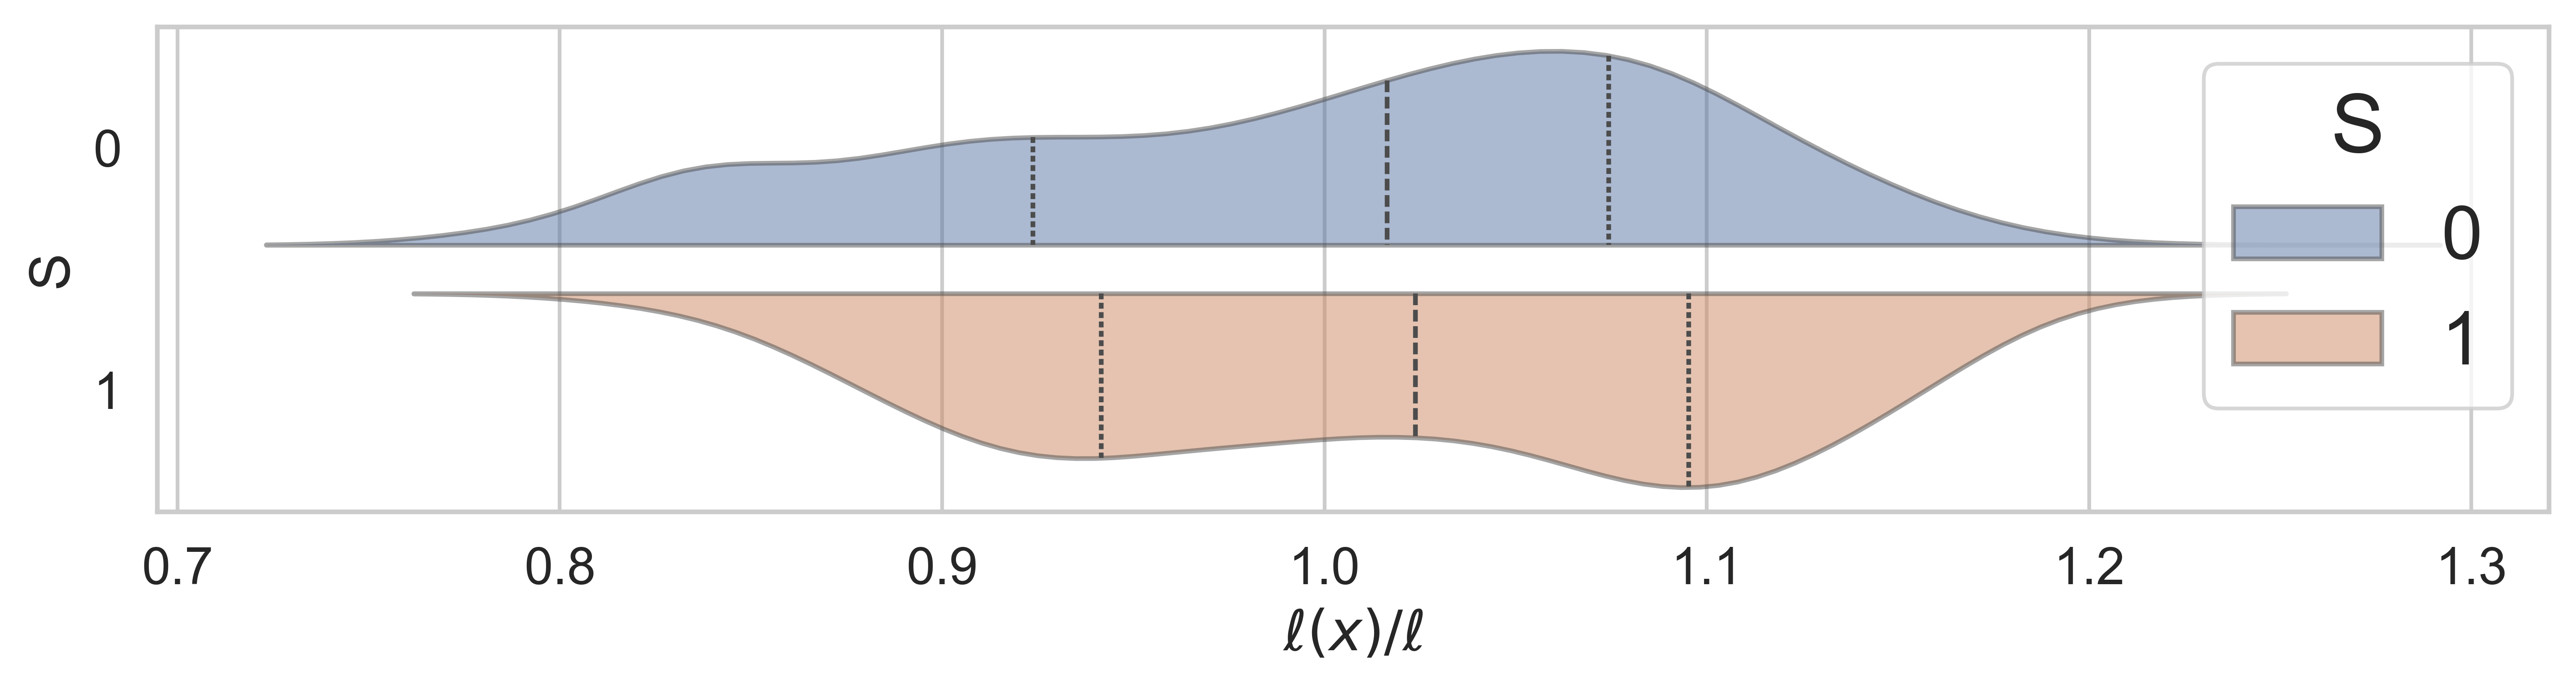

In [179]:
data_dummy_logit["pi(x)/pi"] = data_dummy_logit["pi(x)"] / data_dummy_logit["S"].mean()
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.set(font_scale=1.8, style="whitegrid")
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="S",
    hue="S",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    bw=0.25,
)
plt.xlabel(r"$\ell(x)/{\ell}$")
plt.tight_layout()
plt.savefig("selection_logit.pdf")

Text(0.5, 0, '$\\ell(x)/\\overline{\\ell}$')

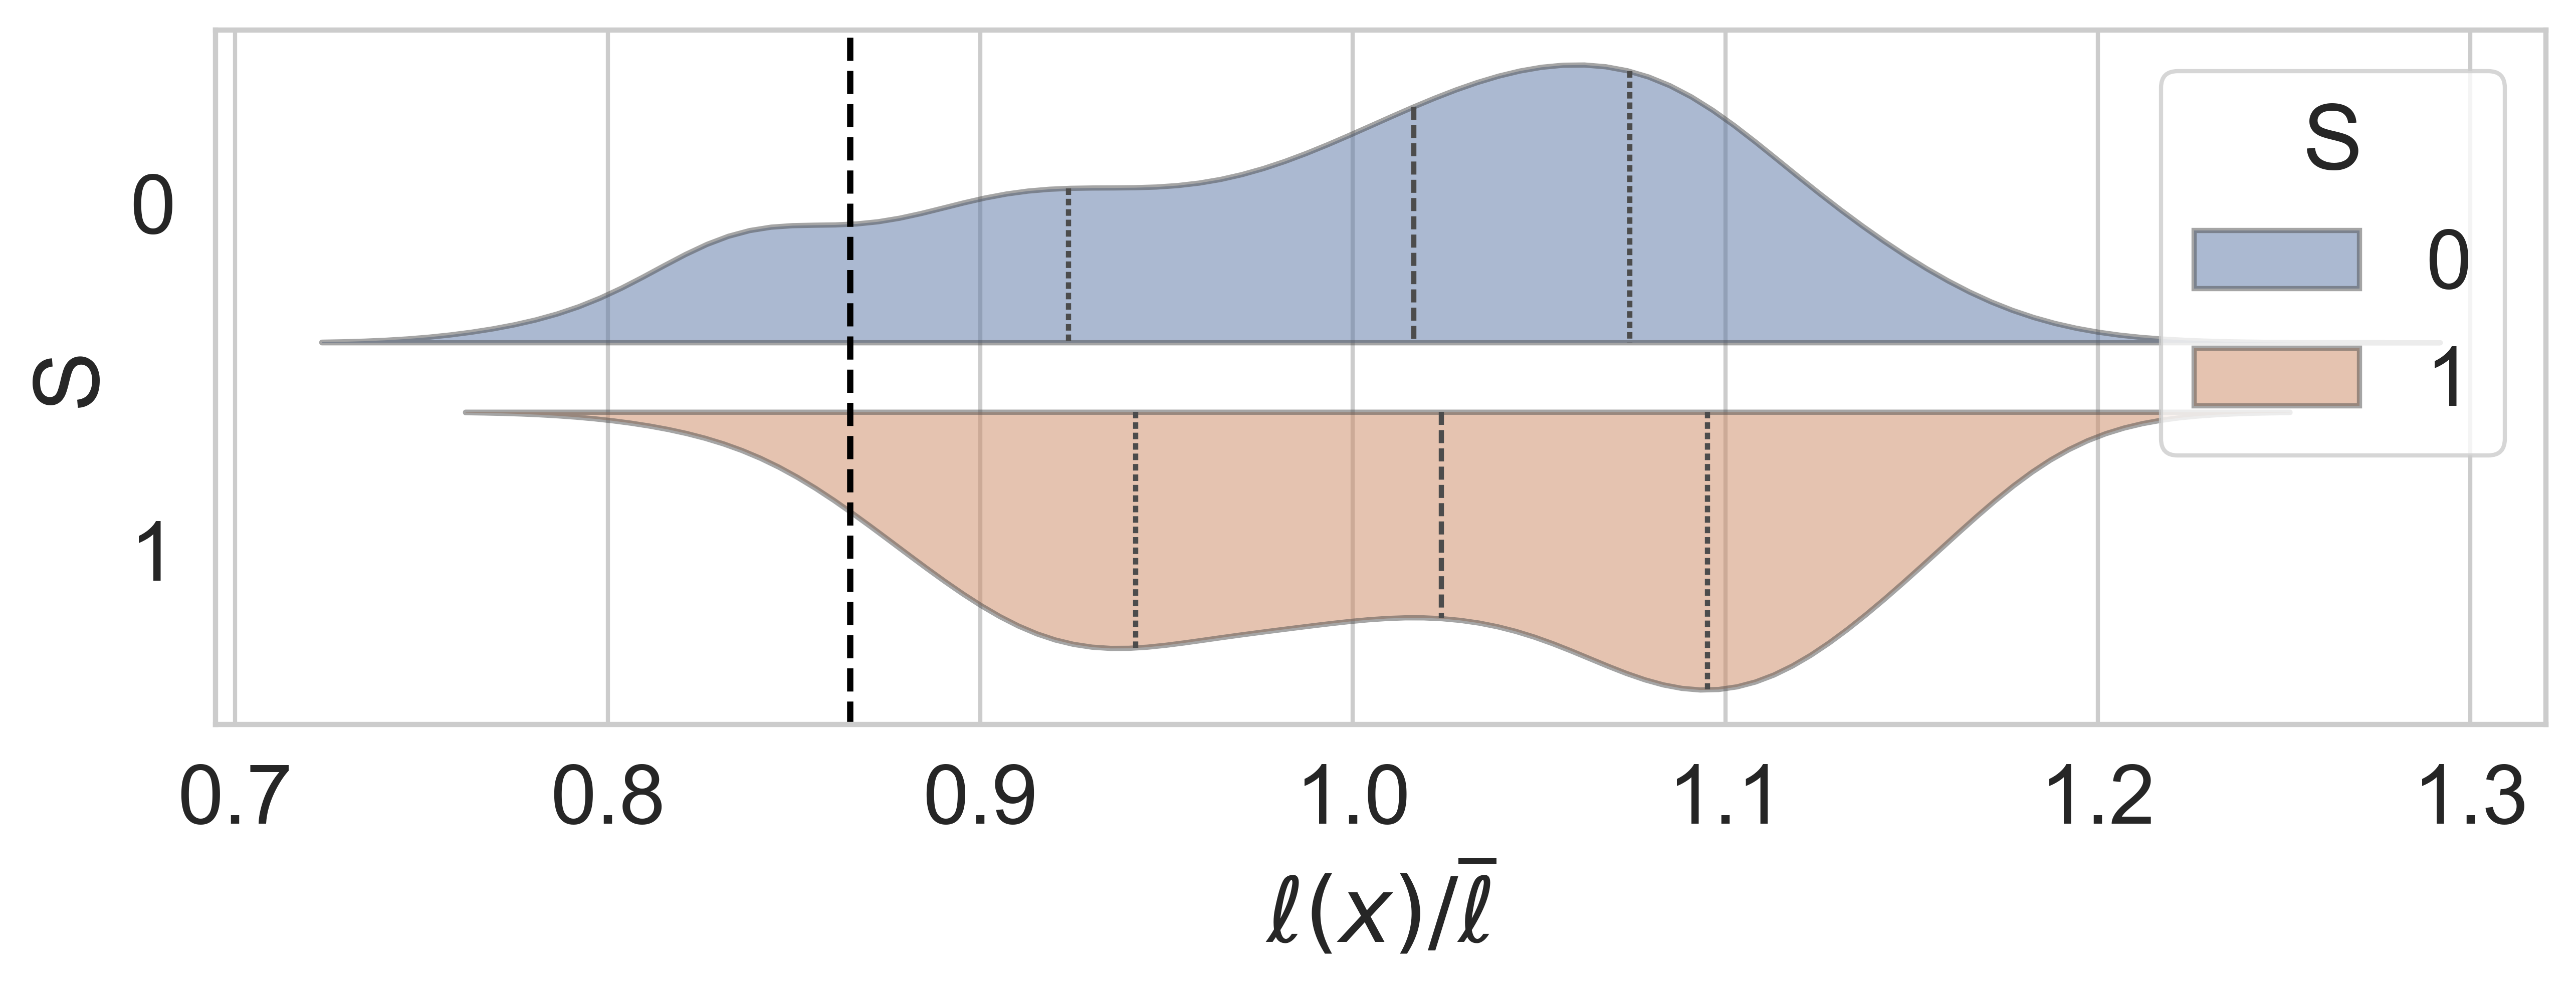

In [180]:
sns.set(font_scale=1.8, style="whitegrid")
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.violinplot(
    data=data_dummy_logit,
    y="S",
    hue="S",
    x="pi(x)/pi",
    orient="h",
    split="True",
    inner="quart",
    alpha=0.5,
    bw=0.25,
)
plt.axvline(0.865, c="black", ls="--")
plt.xlabel(r"$\ell(x)/\overline{\ell}$")

In [181]:
data_dummy_logit = data_dummy_logit.drop(columns=X.columns, errors="ignore")
data_dummy_logit.mean()

S              0.001715
med_met        0.000714
opioiduse24    0.001215
pi(x)          0.001715
pi(x)/pi       0.999982
dtype: float64

#### Ad-hoc $w(x) = ( \ell(x)/\ell > 0.87 )$

In [183]:
data_dummy_logit["w (predefined threshold)"] = (
    (
        (data_dummy_logit["pi(x)"] / S.mean())
        / ((1 - data_dummy_logit["pi(x)"]) / (1 - S.mean()))
    )
    > 0.87
).astype(int)
data_dummy_logit.mean()

print(
    r"Post Pruning, ATTE: %.3f ± %.3f"
    % (
        100 * df_v["te"].loc[data_dummy_logit["w (predefined threshold)"] == 1].mean(),
        100 * df_v["te"].loc[data_dummy_logit["w (predefined threshold)"] == 1].sem(),
    )
)

Post Pruning, ATTE: -8.641 ± 4.740


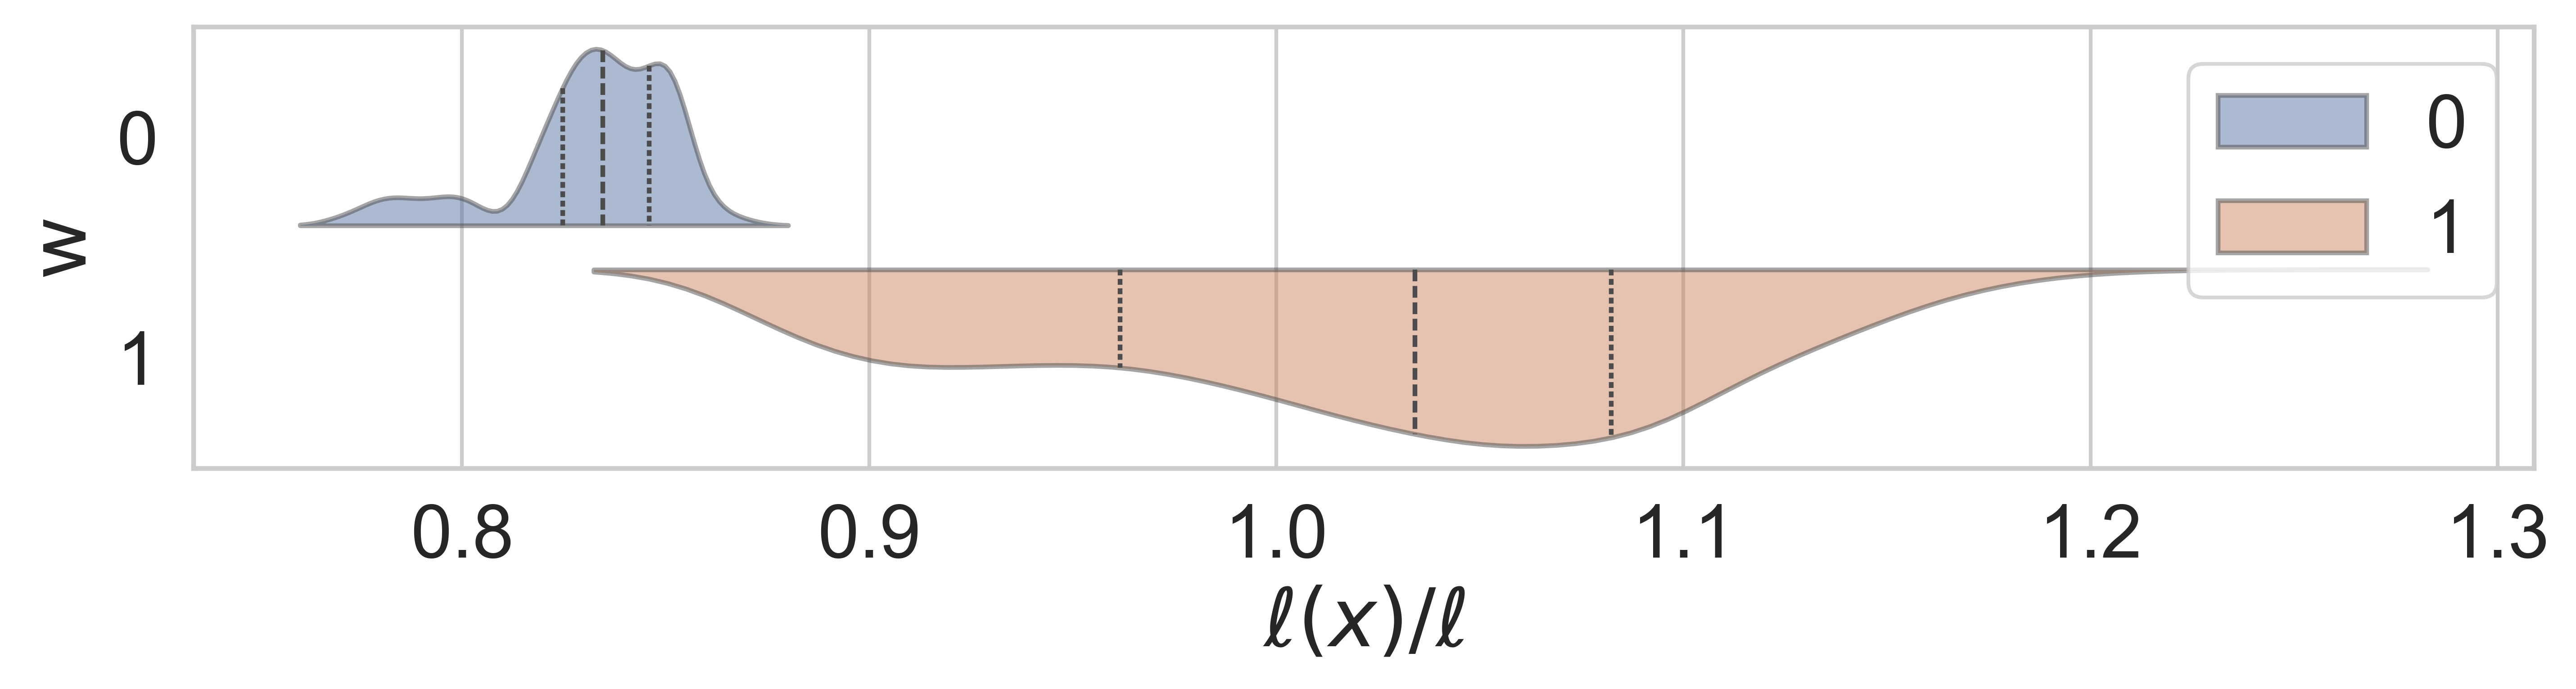

In [184]:
data_dummy_logit["pi(x)/pi"] = data_dummy_logit["pi(x)"] / data_dummy_logit["S"].mean()
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.set(font_scale=1.8, style="whitegrid")
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="w (predefined threshold)",
    hue="w (predefined threshold)",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    bw=0.25,
)
plt.xlabel(r"$\ell(x)/{\ell}$")
plt.ylabel("w")
plt.legend()
plt.tight_layout()
plt.savefig("underrep_logit_adhoc.pdf")

#### Optimized Selection Score $w(x)$

In [254]:
np.random.seed(42)
a_vals = np.linspace(0.83, 0.86, num=5000)


def obj(a):
    data_dummy_logit["w (optimal threshold)"] = (
        data_dummy_logit["pi(x)/pi"] > a
    ).astype(int)
    val = 100 * df_v["te"].loc[data_dummy_logit["w (optimal threshold)"] == 1].sem()
    return val


objs = [obj(a) for a in a_vals]

plt.axhline(100 * df_v["te"].sem())
sns.lineplot(x=a_vals, y=objs)



sns.set(font_scale=1.8, style="whitegrid")
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.violinplot(
    data=data_dummy_logit,
    y="S",
    hue="S",
    x="pi(x)/pi",
    orient="h",
    split="True",
    inner="quart",
    alpha=0.5,
    bw=0.25,
)
plt.axvline(a_vals[np.argmin(objs)], c="red", ls="--")
plt.axvline(0.87, c="black", ls="--")
plt.xlabel(r"$\ell(x)/\overline{\ell}$")

data_dummy_logit["w (optimal threshold)"] = (
    data_dummy_logit["pi(x)/pi"] > a_vals[np.argmin(objs)]
).astype(int)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 6), dpi=600)
sns.set(font_scale=1.8, style="whitegrid")
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="w (predefined threshold)",
    hue="w (predefined threshold)",
    split=True,
    orient="h",
    ax=ax[0],
    alpha=0.5,
    inner="quart",
    bw=0.25,
)
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="w (optimal threshold)",
    hue="w (optimal threshold)",
    split=True,
    orient="h",
    ax=ax[1],
    alpha=0.5,
    inner="quart",
    bw=0.25,
)
plt.xlabel(r"$\ell(x)/{\ell}$")
plt.tight_layout()
plt.savefig("underrep_logit_opt.pdf")

a_vals[np.argmin(objs)], objs[np.argmin(objs)], data_dummy_logit[
    "w (optimal threshold)"
].loc[data_dummy_logit["S"] == 1].mean()

In [261]:
print(
    r"Pre Pruning, ATTE: %.3f ± %.3f"
    % (
        100 * df_v["te"].mean(),
        100 * df_v["te"].sem(),
    )
)

print(
    r"Post Pruning (using predefined $\pi(x)$ threshold), ATTE: %.3f ± %.3f"
    % (
        100
        * df_v["te"]
        .loc[data_dummy_logit["w (predefined threshold)"].astype(int) == 1]
        .mean(),
        100
        * df_v["te"]
        .loc[data_dummy_logit["w (predefined threshold)"].astype(int) == 1]
        .sem(),
    )
)

print(
    r"Post Pruning (using optimal $\pi(x)$ threshold), ATTE: %.3f ± %.3f"
    % (
        100
        * df_v["te"]
        .loc[data_dummy_logit["w (optimal threshold)"].astype(int) == 1]
        .mean(),
        100
        * df_v["te"]
        .loc[data_dummy_logit["w (optimal threshold)"].astype(int) == 1]
        .sem(),
    )
)

Pre Pruning, ATTE: -9.724 ± 4.680
Post Pruning (using predefined $\pi(x)$ threshold), ATTE: -8.641 ± 4.740
Post Pruning (using optimal $\pi(x)$ threshold), ATTE: -10.171 ± 4.677


## Characterizing Underrepresented Population via Indicator $w(x)$

(1271, 10)
(-0.27744219366568484, 0.04642402571890069, -0.09724260216535789, 0.046783414610324696)


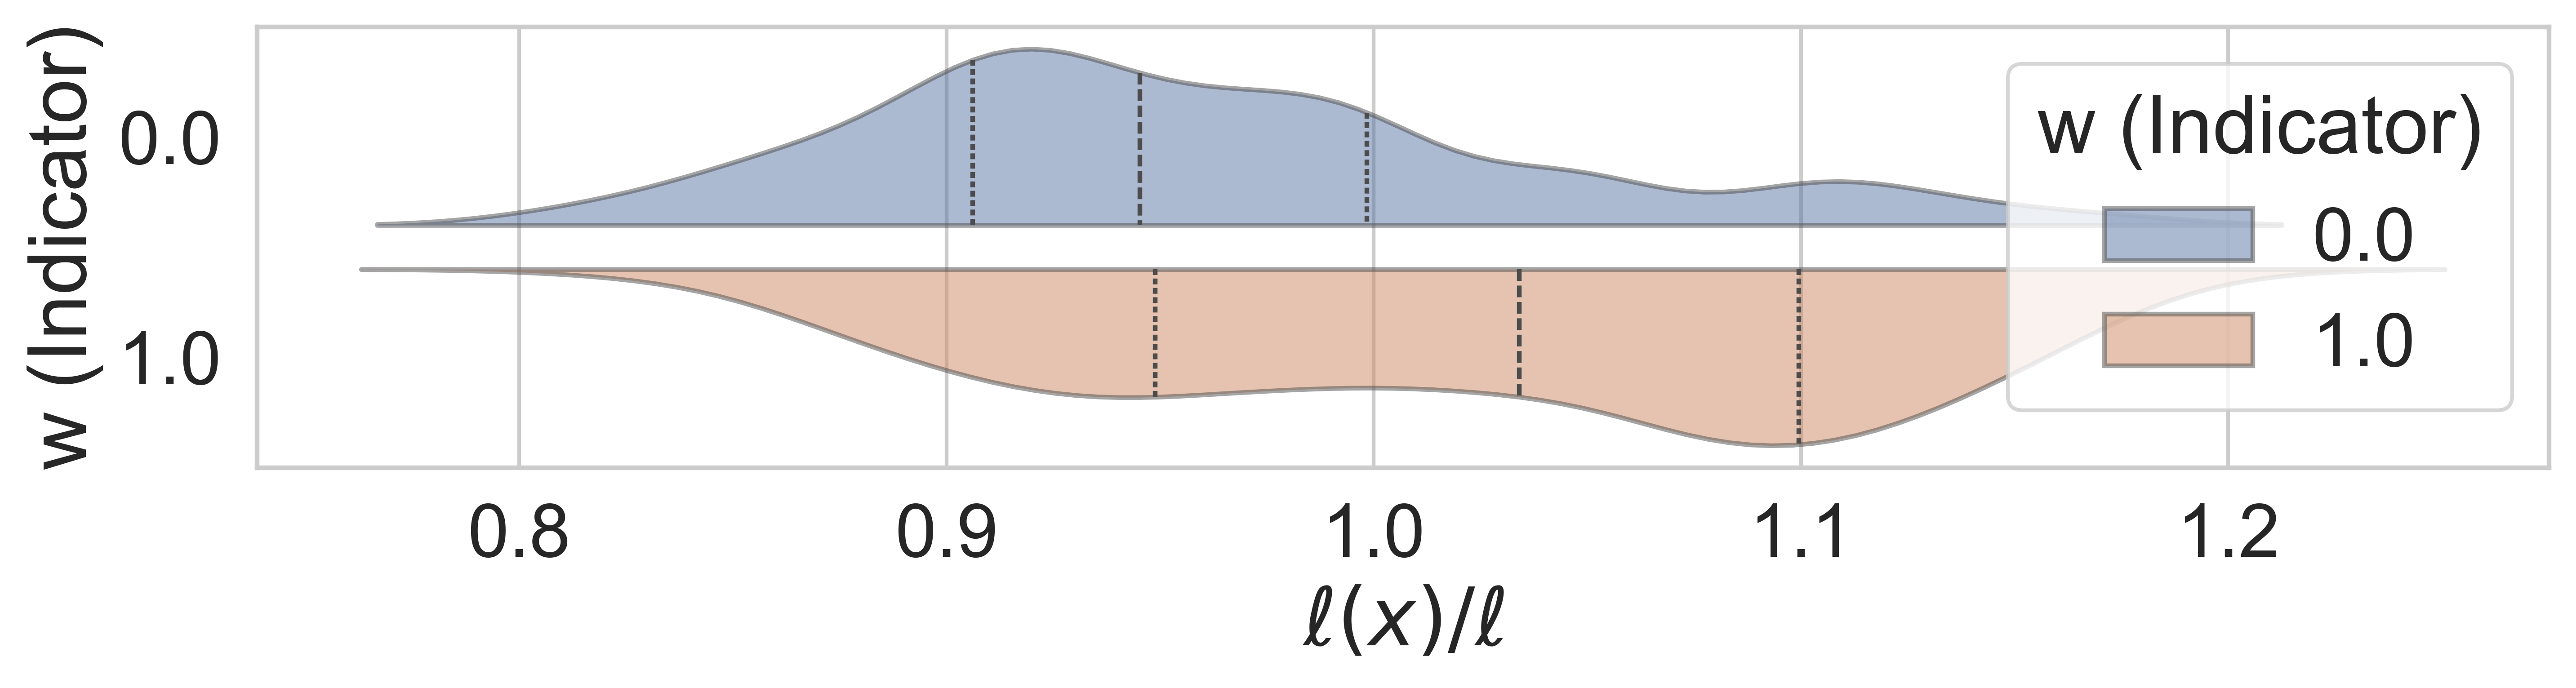

In [308]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
np.random.seed(42)
D_labels, f, testing_data = learn.kmeans_opt(
    data=data_dummy,
    outcome=outcome,
    k=400,
    treatment=treatment,
    sample=sample,
    threshold=1,
)


data_dummy_logit["w (Indicator)"] = D_labels["w"].astype(int)

fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="w (Indicator)",
    hue="w (Indicator)",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    bw=0.25,
)

plt.xlabel(r"$\ell(x)/{\ell}$")
plt.tight_layout()
plt.savefig("underrep_indicator.pdf")

In [311]:
print(
    r"Post Pruning (using optimal $\pi(x)$ threshold), ATTE: %.3f ± %.3f"
    % (
        100 * df_v["te"].loc[data_dummy_logit["w (Indicator)"] == 1].mean(),
        100 * df_v["te"].loc[data_dummy_logit["w (Indicator)"] == 1].sem(),
    )
)

Post Pruning (using optimal $\pi(x)$ threshold), ATTE: -27.744 ± 4.613


## Characterizing Underrepresented Population via ROOT

In [399]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
np.random.seed(42)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_dummy.drop(columns=["w"], errors="ignore"),
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=0.25,
    num_trees=5000,
    vote_threshold=9 / 10,
    # top_k_trees=True,
    # k=5,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
# print("Baseline Objective:%.4f" % (baseline_loss))

ATE Est: -0.0972
leaf              0.200000
Hx Cannabis       0.099778
Age               0.007245
Hx Amphetamine    0.098416
Male              0.039065
Hx Benzo          0.063748
IV Drug Use       0.160499
White             0.112936
Black             0.151415
Hispanic          0.052688
Other Race        0.014210
dtype: float64


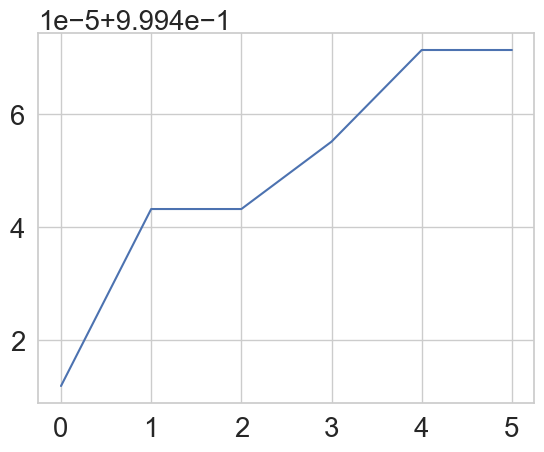

In [409]:
local_obj = pd.DataFrame(
    np.array([w_forest[i]["local objective"] for i in range(len(w_forest))]),
    columns=["Objective"],
).sort_values(by="Objective")

top_k = 6
plt.plot((local_obj.iloc[:top_k] / baseline_loss)["Objective"].values)

In [410]:
w_rash = [
    "w_tree_%d" % (i)
    for i in range(len(w_forest))
    if i in list(local_obj.iloc[:top_k].index)
]
avg_votes = (D_forest[w_rash].mean(axis=1) >= 0.99).astype(int)
D_rash["w_opt"] = avg_votes

np.random.seed(0)
num_trees = 1
explainer = tree.DecisionTreeClassifier(max_depth=8).fit(
    X.loc[avg_votes.index], avg_votes
)

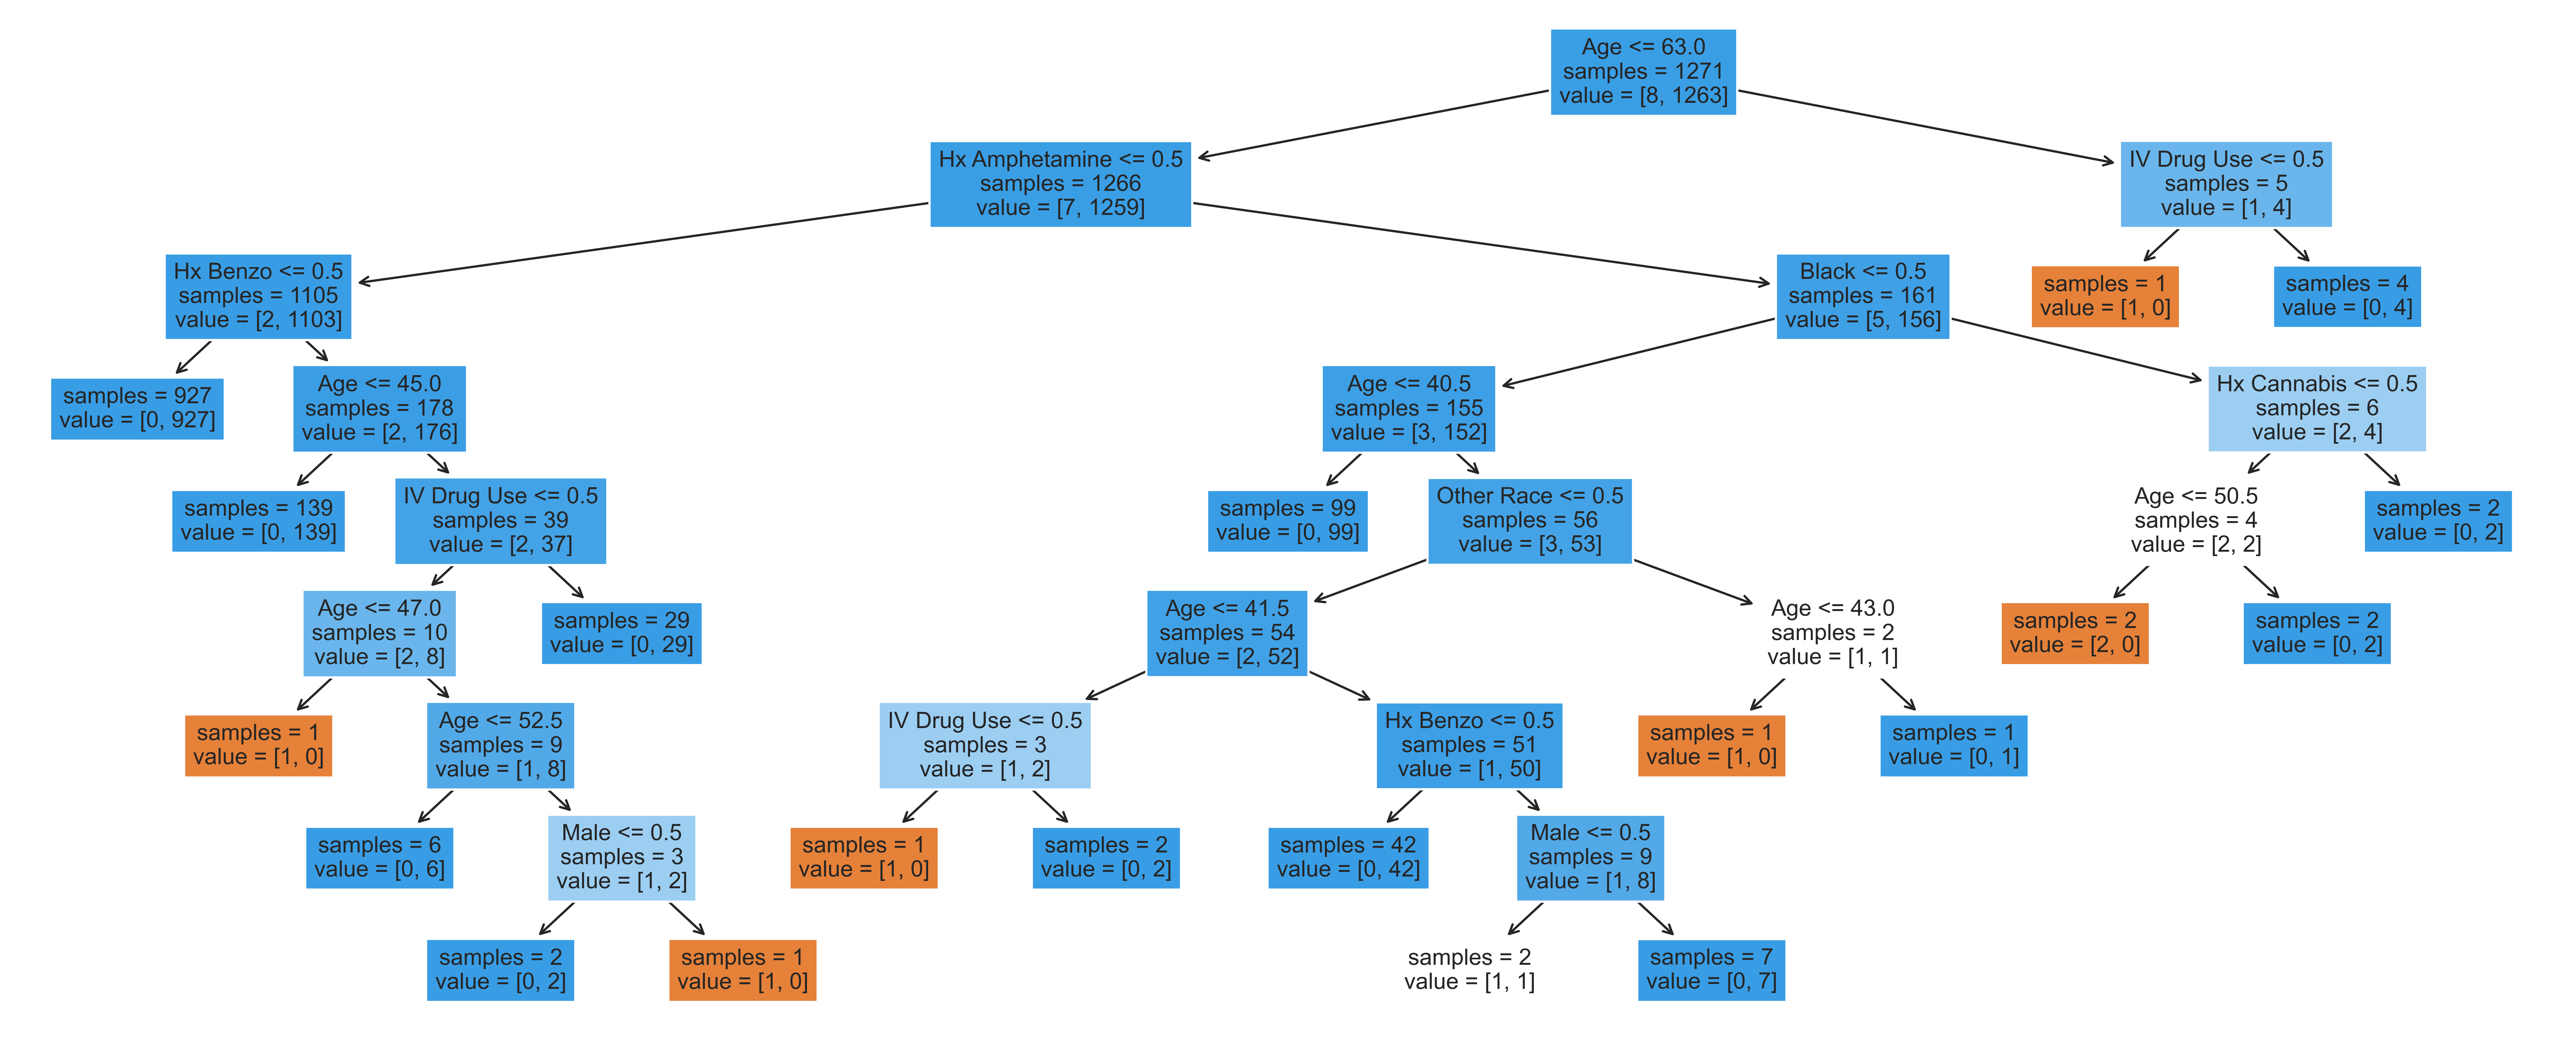

In [411]:
fig, ax = plt.subplots(nrows=num_trees, figsize=(20, 8), dpi=600)
for i in range(num_trees):
    if num_trees == 1:
        tree.plot_tree(
            explainer,  # .estimators_[i, 0],
            feature_names=X.columns,
            ax=ax,
            filled=True,
            fontsize=10,
            # proportion=True,
            impurity=False,
        )
    else:
        tree.plot_tree(
            explainer.estimators_[i, 0],
            feature_names=X.columns,
            ax=ax[i],
            filled=True,
            fontsize=10,
            # proportion=True,
        )
plt.savefig("tedsa_ctn27.pdf", dpi=600)

In [412]:
w = explainer.predict(data_dummy[X.columns])
data_dummy["w"] = w

pd.concat(
    [
        data_dummy.groupby(by="S").mean().T.round(4),
        data_dummy.loc[data_dummy["w"] == 1].groupby(by="S").mean().T.round(4),
    ],
    axis=1,
)

S                     0        1        0        1
Hx Cannabis      0.1147   0.2864   0.1155   0.2884
Age             38.0700  36.8812  37.8073  36.7932
Hx Amphetamine   0.0665   0.1267   0.0652   0.1228
Male             0.5842   0.6774   0.5830   0.6783
Hx Benzo         0.0561   0.1660   0.0531   0.1640
IV Drug Use      0.5376   0.6994   0.5433   0.7005
med_met          0.0000   0.4162   0.0000   0.4120
opioiduse24      0.0000   0.7089   0.0000   0.7068
White            0.6548   0.6758   0.6591   0.6775
Black            0.1487   0.0858   0.1445   0.0848
Hispanic         0.1416   0.1621   0.1421   0.1624
Other Race       0.0549   0.0763   0.0543   0.0753
w                0.9872   0.9929   1.0000   1.0000

In [413]:
D_rash["w_opt"] = explainer.predict(X.loc[avg_votes.index])
print(
    r"Post Pruning, ATTE: %.3f ± %.3f"
    % (
        100 * D_rash["v"].loc[D_rash["w_opt"].astype(int) == 1].mean(),
        100 * D_rash["v"].loc[D_rash["w_opt"].astype(int) == 1].sem(),
    )
)

Post Pruning, ATTE: -11.674 ± 4.668


In [414]:
data_dummy_logit["w (ROOT)"] = D_rash["w_opt"].astype(int)
fig, ax = plt.subplots(nrows=4, sharex=True, sharey=True, figsize=(10, 15), dpi=600)
sns.violinplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (predefined threshold)",
    hue="w (predefined threshold)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    alpha=0.25,
    ax=ax[0],
    inner="quart",
    fill=True,
    hue_order=[1, 0],
    legend=False,
)
sns.swarmplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    x="pi(x)/pi",
    y="w (predefined threshold)",
    hue="w (predefined threshold)",
    # split=True,
    orient="h",
    ax=ax[0],
    size=5,
    # alpha=0.5,
    # inner="quart",
    # fill=True,
    legend=False,
    hue_order=[1, 0],
)
ax[0].set_ylabel("")
ax[0].axvline(0.87, ls="--", c="black")
ax[0].set_title("(a) Predefined Defined Threshold on Selection Score")
sns.violinplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (optimal threshold)",
    hue="w (optimal threshold)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    alpha=0.25,
    ax=ax[1],
    inner="quart",
    fill=True,
    hue_order=[1, 0],
    legend=False,
)
sns.swarmplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    x="pi(x)/pi",
    y="w (optimal threshold)",
    hue="w (optimal threshold)",
    # split=True,
    orient="h",
    ax=ax[1],
    size=5,
    # alpha=0.5,
    # inner="quart",
    # fill=True,
    legend=False,
    hue_order=[1, 0],
)
ax[1].set_ylabel("")
ax[1].axvline(a_vals[np.argmin(objs)], ls="--", c="black")
ax[1].set_title("(b) Optimized Threshold on Selection Score")
sns.violinplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (ROOT)",
    hue="w (ROOT)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    alpha=0.25,
    ax=ax[2],
    inner="quart",
    fill=True,
    hue_order=[1, 0],
)
sns.swarmplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (ROOT)",
    hue="w (ROOT)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    # alpha=0.5,
    ax=ax[2],
    size=5,
    # inner="quart",
    # fill=True,
    legend=False,
    hue_order=[1, 0],
)
ax[2].set_title("(c) ROOT")
ax[2].legend(title="w")
ax[2].set_ylabel("")

sns.violinplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (Indicator)",
    hue="w (Indicator)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    alpha=0.25,
    ax=ax[3],
    inner="quart",
    fill=True,
    legend=False,
    hue_order=[1, 0],
)
sns.swarmplot(
    data=data_dummy_logit.loc[data_dummy_logit["S"] == 1].astype(float),
    y="w (Indicator)",
    hue="w (Indicator)",
    x="pi(x)/pi",
    orient="h",
    # split=True,
    # alpha=0.5,
    ax=ax[3],
    size=5,
    # inner="quart",
    # fill=True,
    legend=False,
    hue_order=[1, 0],
)
ax[3].set_title("(d) Indicator")
ax[3].set_ylabel("")
# plt.ylabel("w")
# plt.legend(title="w")
plt.xlabel(r"$\hat{\ell}(x)/\hat{\ell}$")
plt.tight_layout()
plt.savefig("underrep_root.pdf")

print(
    (
        D_rash.loc[D_rash["w_opt"] == 1]["v"].mean(),
        D_rash.loc[D_rash["w_opt"] == 0]["v"].mean(),
    )
)

(-0.11673729623981949, 2.636346722498033)
